In [1]:
import os
import os.path as op

import numpy as np
from scipy.stats import pearsonr

import nibabel as nib
from nilearn import datasets, image

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap
from seaborn import kdeplot

import networkx as nx
from sklearn.cluster import KMeans

import importlib

import dgsp
import bimod_plots as plot
import clustering as e_clust

In [2]:
# CopyPasted from utils.py in other repo:
import pickle

def save(pickle_filename: str, iterable: object) -> None:
    """
    Pickle an object to a file.

    Parameters
    ----------
    pickle_filename : str
        Path to the file where the object will be pickled.
    iterable : object
        The object to be pickled.

    Returns
    -------
    None
    """
    with open(pickle_filename, "wb") as handle:
        pickle.dump(iterable, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load(pickle_filename: str) -> object:
    """
    Load a pickled object from the specified file.

    Parameters
    ----------
    pickle_filename : str
        The filename of the pickled object to load.

    Returns
    -------
    object
        The loaded object.
    """
    with open(pickle_filename, "rb") as handle:
        b = pickle.load(handle)
    return b

In [3]:
path_to_data = "./data/brain"

# Could be 50, 100, 200, 400
delay_max = 100
#delay_max = 100
scale = 1

undirected = True

filename = f"bundle_probability_atlas-scale{scale}.pkl"

bundle_prob = load(op.join(path_to_data, filename))
bundle_prob = bundle_prob[:-2][:, :-2]
bundle_prob -= np.diag(np.diag(bundle_prob))
ftract_prob = load(op.join(path_to_data, f"adj_probability_ftract-d{delay_max}-scale{scale}.pkl"))
ftract_prob = ftract_prob[:-2][:, :-2]

print(bundle_prob.shape)
print(ftract_prob.shape)

node_centers = load(op.join(path_to_data, f"roi_centers-ftract-scale{scale}.pkl"))[:82]
height_scale = node_centers[:, 2] - node_centers[:, 2].min()
height_scale = height_scale / height_scale.max()

scale_to_nroi = {1:"33", 2:"60", 3:"125"}

labels = np.genfromtxt(op.join(path_to_data, f"brain_labels.csv"), dtype=str)

print(f"There are {len(labels)} nodes in the graph")
all_types = ["lh", "rh", "lhsc", "rhsc"]
types_rename = ["Left", "Right", "Left-sub", "Right-sub"]
type2num = {t:i for i, t in enumerate(all_types)}

node_type = [type2num[lab.split("-")[0]] for lab in labels]

k_threshold = 0.9

if undirected:
    k_matrix = (bundle_prob.copy() > k_threshold).astype(int)
    # k_matrix = bundle_prob + bundle_prob.T
else:
    k_matrix = (2 * bundle_prob * ftract_prob)/(ftract_prob + ftract_prob.T)
    k_matrix = (k_matrix >= k_threshold).astype(int)

print("Is it undirected ?", np.allclose(k_matrix, k_matrix.T))
graph = k_matrix.copy()
n_nodes = graph.shape[0]

(82, 82)
(82, 82)
There are 82 nodes in the graph
Is it undirected ? True


In [22]:
path_to_all_fmri = "/Users/acionca/data/HCP-MIP/atlased/Laus2008_smth6_lp0.15"

task = "rest1_dir-LR"
# task = "rest1"
# task = "motor"
# task = "emotion"
# task = "gambling"
# task = "language"

all_fnames = sorted([f for f in os.listdir(path_to_all_fmri) if task in f])
print(all_fnames)
print(f"Found {len(all_fnames)} matching files")

all_nodals = [np.genfromtxt(op.join(path_to_all_fmri, f), delimiter=",") for f in all_fnames]

nodal_fmri = np.concatenate(all_nodals, axis=0)
print(nodal_fmri.shape)

test = np.concatenate(all_nodals[:len(all_nodals)//2], axis=0)
retest = np.concatenate(all_nodals[len(all_nodals)//2:], axis=0)

ntest = len(test)
nretest = len(retest)
print(f"Test shape: {test.shape}")
print(f"Retest shape: {retest.shape}")

['sub-100307_task-rest1_dir-LR_timeseries.csv', 'sub-100408_task-rest1_dir-LR_timeseries.csv', 'sub-101107_task-rest1_dir-LR_timeseries.csv', 'sub-101309_task-rest1_dir-LR_timeseries.csv', 'sub-101915_task-rest1_dir-LR_timeseries.csv', 'sub-103111_task-rest1_dir-LR_timeseries.csv', 'sub-103414_task-rest1_dir-LR_timeseries.csv', 'sub-103818_task-rest1_dir-LR_timeseries.csv', 'sub-105014_task-rest1_dir-LR_timeseries.csv', 'sub-105115_task-rest1_dir-LR_timeseries.csv', 'sub-106016_task-rest1_dir-LR_timeseries.csv', 'sub-108828_task-rest1_dir-LR_timeseries.csv', 'sub-110411_task-rest1_dir-LR_timeseries.csv', 'sub-111312_task-rest1_dir-LR_timeseries.csv', 'sub-111716_task-rest1_dir-LR_timeseries.csv', 'sub-113619_task-rest1_dir-LR_timeseries.csv', 'sub-113922_task-rest1_dir-LR_timeseries.csv', 'sub-114419_task-rest1_dir-LR_timeseries.csv', 'sub-115320_task-rest1_dir-LR_timeseries.csv', 'sub-116524_task-rest1_dir-LR_timeseries.csv']
Found 20 matching files
(23971, 82)
Test shape: (11983, 82)

## Benchmarking

In [23]:
importlib.reload(e_clust)

operators = ["naive", "modularity", "laplacian", "adjacency"]
operators = ["modularity", "laplacian"]

norm_cluster = True

all_comps = np.arange(2, 20)
all_k_clusters = np.arange(2, 20)

stat_test = np.concatenate([test.T, test.T], axis=0).T
stat_retest = np.concatenate([retest.T, retest.T], axis=0).T

stat_test_edge, stat_retest_edge = e_clust.prepare_benchmark(graph, stat_test, stat_retest, all_comps, operators)

stat_test_edge = stat_test_edge/np.linalg.norm(stat_test_edge, axis=2)[:, :, None]
stat_retest_edge = stat_retest_edge/np.linalg.norm(stat_retest_edge, axis=2)[:, :, None]

Computing for 2 components
Computing for 3 components
Computing for 4 components
Computing for 5 components
Computing for 6 components
Computing for 7 components
Computing for 8 components
Computing for 9 components
Computing for 10 components
Computing for 11 components
Computing for 12 components
Computing for 13 components
Computing for 14 components
Computing for 15 components
Computing for 16 components
Computing for 17 components
Computing for 18 components
Computing for 19 components


In [ ]:
importlib.reload(e_clust)

(test_labels,
 retest_labels,
 test_centroids,
 retest_centroids) = e_clust.benchmark_clustering_fast(
     stat_test_edge,
     stat_retest_edge,
     all_k_clusters=all_k_clusters,
     norm=False)

  0%|          | 0/648 [00:00<?, ?it/s]

In [ ]:
importlib.reload(e_clust)

operators = ["naive", "modularity", "laplacian", "adjacency"]
operators = ["modularity", "laplacian"]

norm_cluster = True

all_comps = np.arange(2, 10)
all_k_clusters = np.arange(2, 15)

stat_test = np.concatenate([test.T, test.T], axis=0).T
stat_retest = np.concatenate([retest.T, retest.T], axis=0).T

# test_labels, retest_labels, test_centroids, retest_centroids = e_clust.benchmark_clustering(graph, stat_test, stat_retest,
#                                                                                             all_comps=all_comps,
#                                                                                             all_k_clusters=all_k_clusters,
#                                                                                             all_operators=operators)

In [ ]:
print(test_labels.shape)
print(retest_labels.shape)

print(len(test_centroids))
print(len(retest_centroids))

print(test_centroids[0].shape)
print(retest_centroids[1].shape)

(13, 8, 2, 23978)
(13, 8, 2, 23984)
13
13
(8, 2, 2, 3072)
(8, 2, 3, 3072)


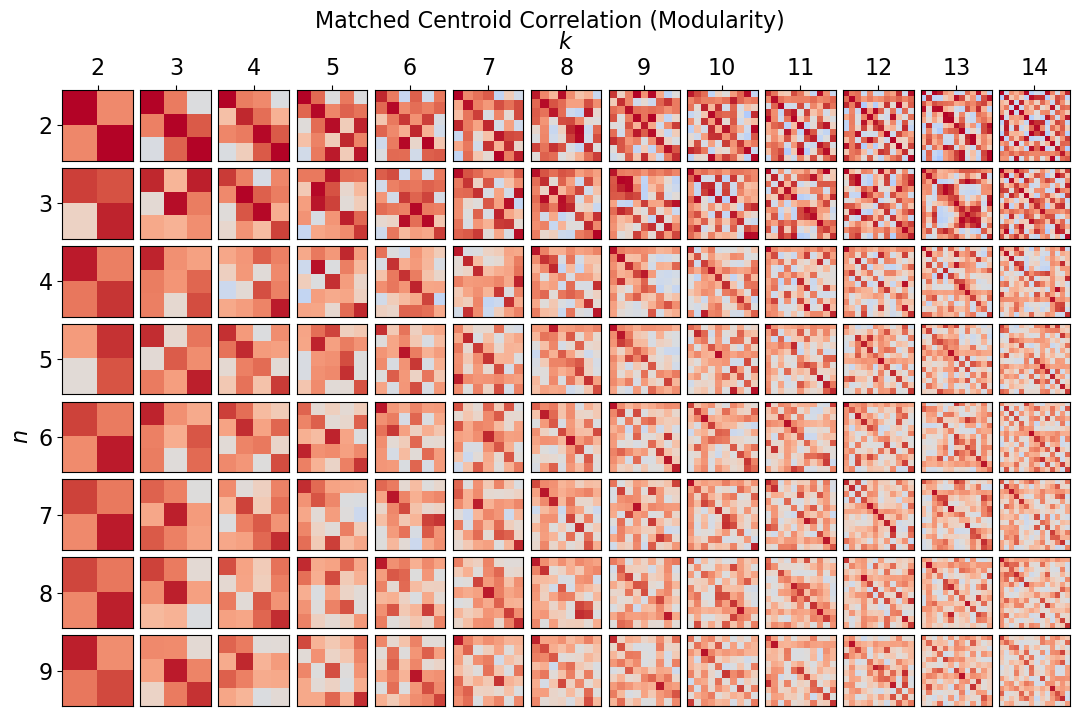

In [ ]:
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

fig, axes = plt.subplots(nrows=len(all_comps), ncols=len(all_k_clusters), figsize=(len(all_k_clusters), len(all_comps)), gridspec_kw={"hspace": 0.1, "wspace": 0.1})

fig.suptitle(f"Matched Centroid Correlation ({operators[0].capitalize()})", fontsize=16)

axes[len(all_comps)//2, 0].set_ylabel(f"$n$", fontsize=16)
axes[0, len(all_k_clusters)//2].set_title(f"$k$", fontsize=16)

all_cent_corr = [np.zeros((len(all_comps), len(operators), k, k)) for k in all_k_clusters]
all_cent_match = [np.zeros((len(all_comps), len(operators), k, k)) for k in all_k_clusters]
all_diag_means = np.zeros((len(all_k_clusters), len(all_comps), len(operators)), dtype=float)
all_off_diag_means = np.zeros((len(all_k_clusters), len(all_comps), len(operators)), dtype=float)

for k, k_clust in enumerate(all_k_clusters):
    for n, n_comp in enumerate(all_comps):
        for i, operator in enumerate(operators):
            corr_input = np.vstack([test_centroids[k][n, i], retest_centroids[k][n, i]])
            all_cent_corr[k][n, i] = np.corrcoef(corr_input)[:k_clust][:, k_clust:]

            row_ind, col_ind = linear_sum_assignment(all_cent_corr[k][n, i], maximize=True)
            all_cent_match[k][n, i] = all_cent_corr[k][n, i][row_ind][:, col_ind]

            all_diag_means[k, n, i] = np.diag(all_cent_match[k][n, i]).mean()
            # all_off_diag_means[k, n, i] = all_cent_match[k][n, i][~np.eye(k_clust, dtype=bool)].mean()
            all_off_diag_means[k, n, i] = np.abs(all_cent_match[k][n, i][~np.eye(k_clust, dtype=bool)]).mean()
        
        axes[n, k].imshow(all_cent_match[k][n, 0], vmin=-1, vmax=1, cmap="coolwarm")
        axes[n, k].set_xticks([])
        axes[n, k].set_yticks([])

        axes[n, 0].set_yticks([0.5], [f"{n_comp}"], fontsize=16)
    axes[0, k].set_xticks([(k_clust-1)/2], [f"{k_clust}"], fontsize=16)
    axes[0, k].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

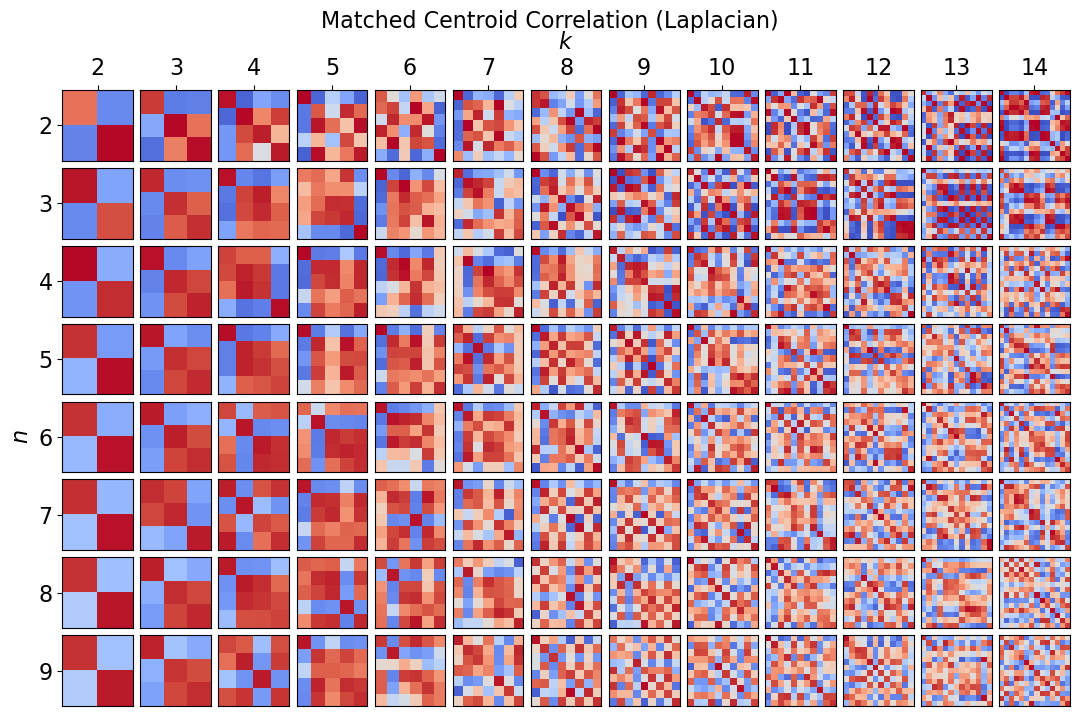

In [ ]:
fig, axes = plt.subplots(nrows=len(all_comps), ncols=len(all_k_clusters), figsize=(len(all_k_clusters), len(all_comps)), gridspec_kw={"hspace": 0.1, "wspace": 0.1})

fig.suptitle(f"Matched Centroid Correlation ({operators[1].capitalize()})", fontsize=16)

axes[len(all_comps)//2, 0].set_ylabel(f"$n$", fontsize=16)
axes[0, len(all_k_clusters)//2].set_title(f"$k$", fontsize=16)

for k, k_clust in enumerate(all_k_clusters):
    for n, n_comp in enumerate(all_comps):
        axes[n, k].imshow(all_cent_match[k][n, 1], vmin=-1, vmax=1, cmap="coolwarm")
        axes[n, k].set_xticks([])
        axes[n, k].set_yticks([])

        axes[n, 0].set_yticks([0.5], [f"{n_comp}"], fontsize=16)
    axes[0, k].set_xticks([(k_clust-1)/2], [f"{k_clust}"], fontsize=16)
    axes[0, k].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

1.1547982801455343 2.8275414974094533


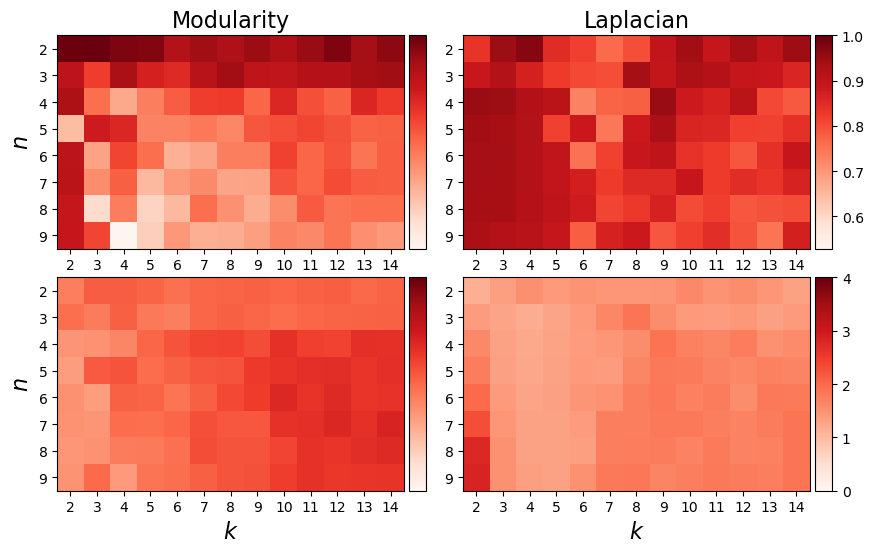

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), gridspec_kw={"hspace": 0.1, "wspace": 0.1})

for i, ax in enumerate(axes[0]):
    ax.set_title(operators[i].capitalize(), fontsize=16)
    # ax.imshow(all_diag_means[:, :, i].T, vmin=-1, vmax=1, cmap="coolwarm")
    ax.imshow(all_diag_means[:, :, i].T, vmin=all_diag_means.min(), vmax=1, cmap="Reds")
    ax.set_xticks(np.arange(len(all_k_clusters)), labels=all_k_clusters)
    ax.set_yticks(np.arange(len(all_comps)), labels=all_comps)
    if i == 0:
        _ = plot.add_cbar(fig, ax, ticks=[])
    else:
        _ = plot.add_cbar(fig, ax)

axes[0, 0].set_ylabel("$n$", fontsize=16)
axes[1, 0].set_ylabel("$n$", fontsize=16)

all_ratios = np.abs(all_diag_means / all_off_diag_means)
print(all_ratios.min(), all_ratios.max())
minval = 0
maxval = 4

for i, ax in enumerate(axes[1]):
    # ax.imshow(all_diag_means[:, :, i].T, vmin=-1, vmax=1, cmap="coolwarm")
    ax.imshow(all_ratios[:, :, i].T, vmin=minval, vmax=maxval, cmap="Reds")
    ax.set_xticks(np.arange(len(all_k_clusters)), labels=all_k_clusters)
    ax.set_yticks(np.arange(len(all_comps)), labels=all_comps)
    ax.set_xlabel("$k$", fontsize=16)
    if i == 0:
        _ = plot.add_cbar(fig, ax, ticks=[])
    else:
        _ = plot.add_cbar(fig, ax)

## Transitions

In [ ]:
importlib.reload(e_clust)

trans_test = np.concatenate([test.T[:, :-1], test.T[:, 1:]], axis=0).T
trans_retest = np.concatenate([retest.T[:, :-1], retest.T[:, 1:]], axis=0).T

trans_t_lab, trans_rt_lab, trans_t_cent, trans_rt_cent = e_clust.benchmark_clustering(graph, trans_test, trans_retest,
                                                                                      all_comps=all_comps,
                                                                                      all_k_clusters=all_k_clusters,
                                                                                      all_operators=operators)


# trans_test_edge, trans_retest_edge = e_clust.prepare_benchmark(graph, trans_test, trans_retest, all_comps, operators)

# (trans_t_lab,
#  trans_rt_lab,
#  trans_t_cent,
#  trans_rt_cent) = e_clust.benchmark_clustering_fast(
#      trans_test_edge,
#      trans_retest_edge,
#      all_k_clusters=all_k_clusters,
#      norm=True)

In [ ]:
importlib.reload(e_clust)

trans_cent_match, trans_diag_means, trans_off_diag_means = e_clust.get_centroid_similarities(trans_t_cent, trans_rt_cent)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), gridspec_kw={"hspace": 0.1, "wspace": 0.1})

for i, ax in enumerate(axes[0]):
    ax.set_title(operators[i].capitalize(), fontsize=16)
    # ax.imshow(all_diag_means[:, :, i].T, vmin=-1, vmax=1, cmap="coolwarm")
    ax.imshow(trans_diag_means[:, :, i].T, vmin=trans_diag_means.min(), vmax=1, cmap="Reds")
    ax.set_xticks(np.arange(len(all_k_clusters)), labels=all_k_clusters)
    ax.set_yticks(np.arange(len(all_comps)), labels=all_comps)
    if i == 0:
        _ = plot.add_cbar(fig, ax, ticks=[])
    else:
        _ = plot.add_cbar(fig, ax)

axes[0, 0].set_ylabel("$n$", fontsize=16)
axes[1, 0].set_ylabel("$n$", fontsize=16)

all_ratios = np.abs(trans_diag_means / trans_off_diag_means)
print(all_ratios.min(), all_ratios.max())
minval = 2
maxval = 6

for i, ax in enumerate(axes[1]):
    # ax.imshow(all_diag_means[:, :, i].T, vmin=-1, vmax=1, cmap="coolwarm")
    ax.imshow(all_ratios[:, :, i].T, vmin=minval, vmax=maxval, cmap="Reds")
    ax.set_xticks(np.arange(len(all_k_clusters)), labels=all_k_clusters)
    ax.set_yticks(np.arange(len(all_comps)), labels=all_comps)
    ax.set_xlabel("$k$", fontsize=16)
    if i == 0:
        _ = plot.add_cbar(fig, ax, ticks=[])
    else:
        _ = plot.add_cbar(fig, ax)

## Static without DC

In [ ]:
importlib.reload(e_clust)

(test_labels_noDC,
 retest_labels_noDC,
 test_centroids_noDC,
 retest_centroids_noDC) = e_clust.benchmark_clustering(graph, stat_test, stat_retest,
                                                  all_comps=all_comps,
                                                  all_k_clusters=all_k_clusters,
                                                  all_operators=operators,
                                                  start_comp=[0, 1])

In [ ]:
(stat_cent_match_noDC,
 stat_diag_means_noDC,
 stat_off_diag_means_noDC,) = e_clust.get_centroid_similarities(test_centroids_noDC, retest_centroids_noDC)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), gridspec_kw={"hspace": 0.1, "wspace": 0.1})

for i, ax in enumerate(axes[0]):
    ax.set_title(operators[i].capitalize(), fontsize=16)
    # ax.imshow(all_diag_means[:, :, i].T, vmin=-1, vmax=1, cmap="coolwarm")
    ax.imshow(stat_diag_means_noDC[:, :, i].T, vmin=stat_diag_means_noDC.min(), vmax=1, cmap="Reds")
    ax.set_xticks(np.arange(len(all_k_clusters)), labels=all_k_clusters)
    ax.set_yticks(np.arange(len(all_comps)), labels=all_comps)
    if i == 0:
        _ = plot.add_cbar(fig, ax, ticks=[])
    else:
        _ = plot.add_cbar(fig, ax)

axes[0, 0].set_ylabel("$n$", fontsize=16)
axes[1, 0].set_ylabel("$n$", fontsize=16)

all_ratios = np.abs(stat_diag_means_noDC / stat_off_diag_means_noDC)
print(all_ratios.min(), all_ratios.max())
minval = 2
maxval = 4

for i, ax in enumerate(axes[1]):
    # ax.imshow(all_diag_means[:, :, i].T, vmin=-1, vmax=1, cmap="coolwarm")
    ax.imshow(all_ratios[:, :, i].T, vmin=minval, vmax=maxval, cmap="Reds")
    ax.set_xticks(np.arange(len(all_k_clusters)), labels=all_k_clusters)
    ax.set_yticks(np.arange(len(all_comps)), labels=all_comps)
    ax.set_xlabel("$k$", fontsize=16)
    if i == 0:
        _ = plot.add_cbar(fig, ax, ticks=[])
    else:
        _ = plot.add_cbar(fig, ax)

In [ ]:
importlib.reload(e_clust)

(trans_t_lab_noDC,
 trans_rt_lab_noDC,
 trans_t_cent_noDC,
 trans_rt_cent_noDC) = e_clust.benchmark_clustering(graph, trans_test, trans_retest,
                                                    all_comps=all_comps,
                                                    all_k_clusters=all_k_clusters,
                                                    all_operators=operators,
                                                    start_comp=[0, 1])

In [ ]:
(trans_cent_match_noDC,
 trans_diag_means_noDC,
 trans_off_diag_means_noDC,) = e_clust.get_centroid_similarities(trans_t_cent_noDC, trans_rt_cent_noDC)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), gridspec_kw={"hspace": 0.1, "wspace": 0.1})

for i, ax in enumerate(axes[0]):
    ax.set_title(operators[i].capitalize(), fontsize=16)
    # ax.imshow(all_diag_means[:, :, i].T, vmin=-1, vmax=1, cmap="coolwarm")
    ax.imshow(trans_diag_means_noDC[:, :, i].T, vmin=trans_diag_means_noDC.min(), vmax=1, cmap="Reds")
    ax.set_xticks(np.arange(len(all_k_clusters)), labels=all_k_clusters)
    ax.set_yticks(np.arange(len(all_comps)), labels=all_comps)
    if i == 0:
        _ = plot.add_cbar(fig, ax, ticks=[])
    else:
        _ = plot.add_cbar(fig, ax)

axes[0, 0].set_ylabel("$n$", fontsize=16)
axes[1, 0].set_ylabel("$n$", fontsize=16)

all_ratios = np.abs(trans_diag_means_noDC / trans_off_diag_means_noDC)
print(all_ratios.min(), all_ratios.max())
minval = 2
maxval = 4

for i, ax in enumerate(axes[1]):
    # ax.imshow(all_diag_means[:, :, i].T, vmin=-1, vmax=1, cmap="coolwarm")
    ax.imshow(all_ratios[:, :, i].T, vmin=minval, vmax=maxval, cmap="Reds")
    ax.set_xticks(np.arange(len(all_k_clusters)), labels=all_k_clusters)
    ax.set_yticks(np.arange(len(all_comps)), labels=all_comps)
    ax.set_xlabel("$k$", fontsize=16)
    if i == 0:
        _ = plot.add_cbar(fig, ax, ticks=[])
    else:
        _ = plot.add_cbar(fig, ax)